In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from MulticoreTSNE import MulticoreTSNE as TSNE
from scipy.stats import entropy

In [4]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import *
from keras.constraints import UnitNorm

from keras.datasets import fashion_mnist, mnist

Using TensorFlow backend.


In [5]:
from gradient_reversal_keras_tf.gradient_reversal_layer import GradientReversal
from utils import *

# Loading and preparing data

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
x_train = x_train.reshape((x_train.shape[0], -1)).astype(np.float32)
x_test = x_test.reshape((x_test.shape[0], -1)).astype(np.float32)

x_train = x_train / 255.
x_test = x_test / 255.

n_classes = len(set(y_train))

In [8]:
BATCH_SIZE = 32
N_EPOCH = 32

INPUT_DIM = x_train.shape[1]
LATENT_DIM = 128
HIDDEN_DIM = 256

# Simple VAE

### Definition and training

In [9]:
# Encoder
inp_e = Input((INPUT_DIM,))
e = Dense(HIDDEN_DIM, activation='relu')(inp_e)
e = Dense(HIDDEN_DIM, activation='relu')(e)

# Reparametrization trick
z_mean = Dense(LATENT_DIM)(e)
z_log_sigma = Dense(LATENT_DIM)(e)
z_code = Lambda(lambda x: x[0] + K.exp(x[1]) * K.random_normal(shape=K.shape(x[0])))([z_mean, z_log_sigma])
           
encoder = Model(inp_e, [z_code, z_mean, z_log_sigma], name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Stacking all together
inp_x = Input((INPUT_DIM,))

z_code, z_mean, z_log_sigma = encoder(inp_x)
reconstruction = decoder(z_code)
kl_divergence = Lambda(lambda x: -0.5 * K.mean(1 + x[1] - K.square(x[0]) - K.exp(x[1]), axis=-1), name='KLD')([z_mean, z_log_sigma])

trainable = Model(inp_x, [reconstruction, kl_divergence])
trainable.compile('rmsprop', ['binary_crossentropy', lambda y_true, y_pred: y_pred])
# trainable.summary()

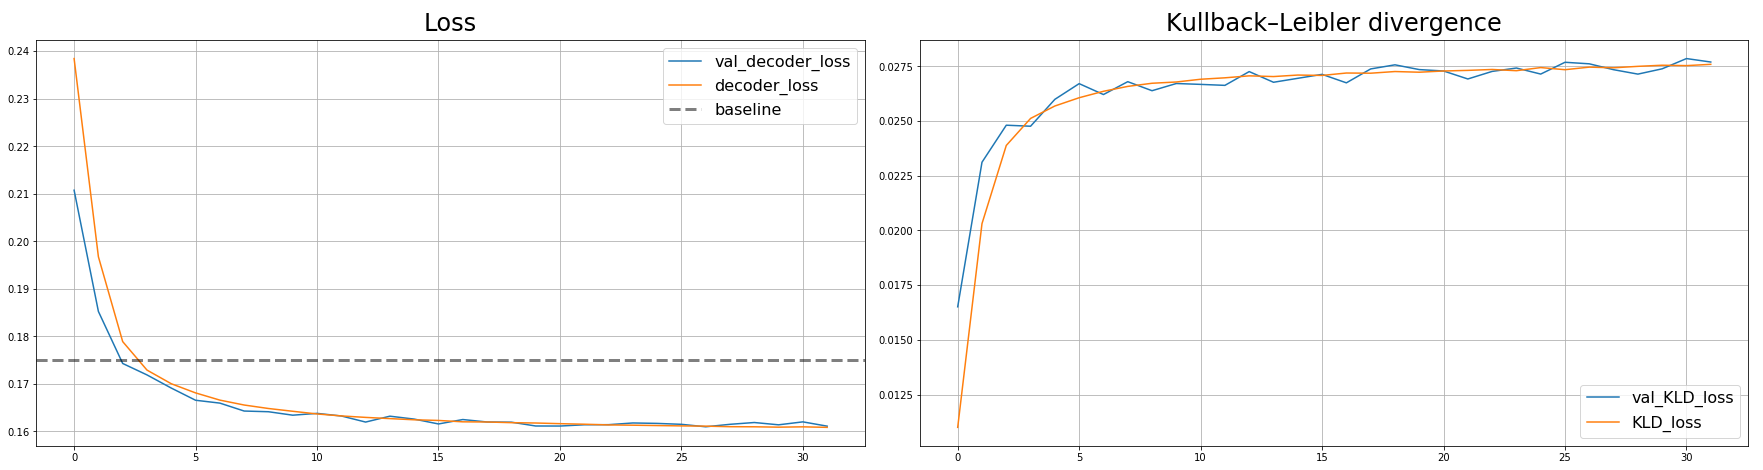

In [10]:
trainable.fit(x=x_train, y=[x_train, np.zeros(x_train.shape[0])], batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=0, 
              validation_data=(x_test, [x_test, np.zeros(x_test.shape[0])]), shuffle=True,
              callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{'baseline': 0.175}}, 
                                            {'text':'Kullback–Leibler divergence', 'loss_signature':'KLD', 'constants':{}}))],)

### Results

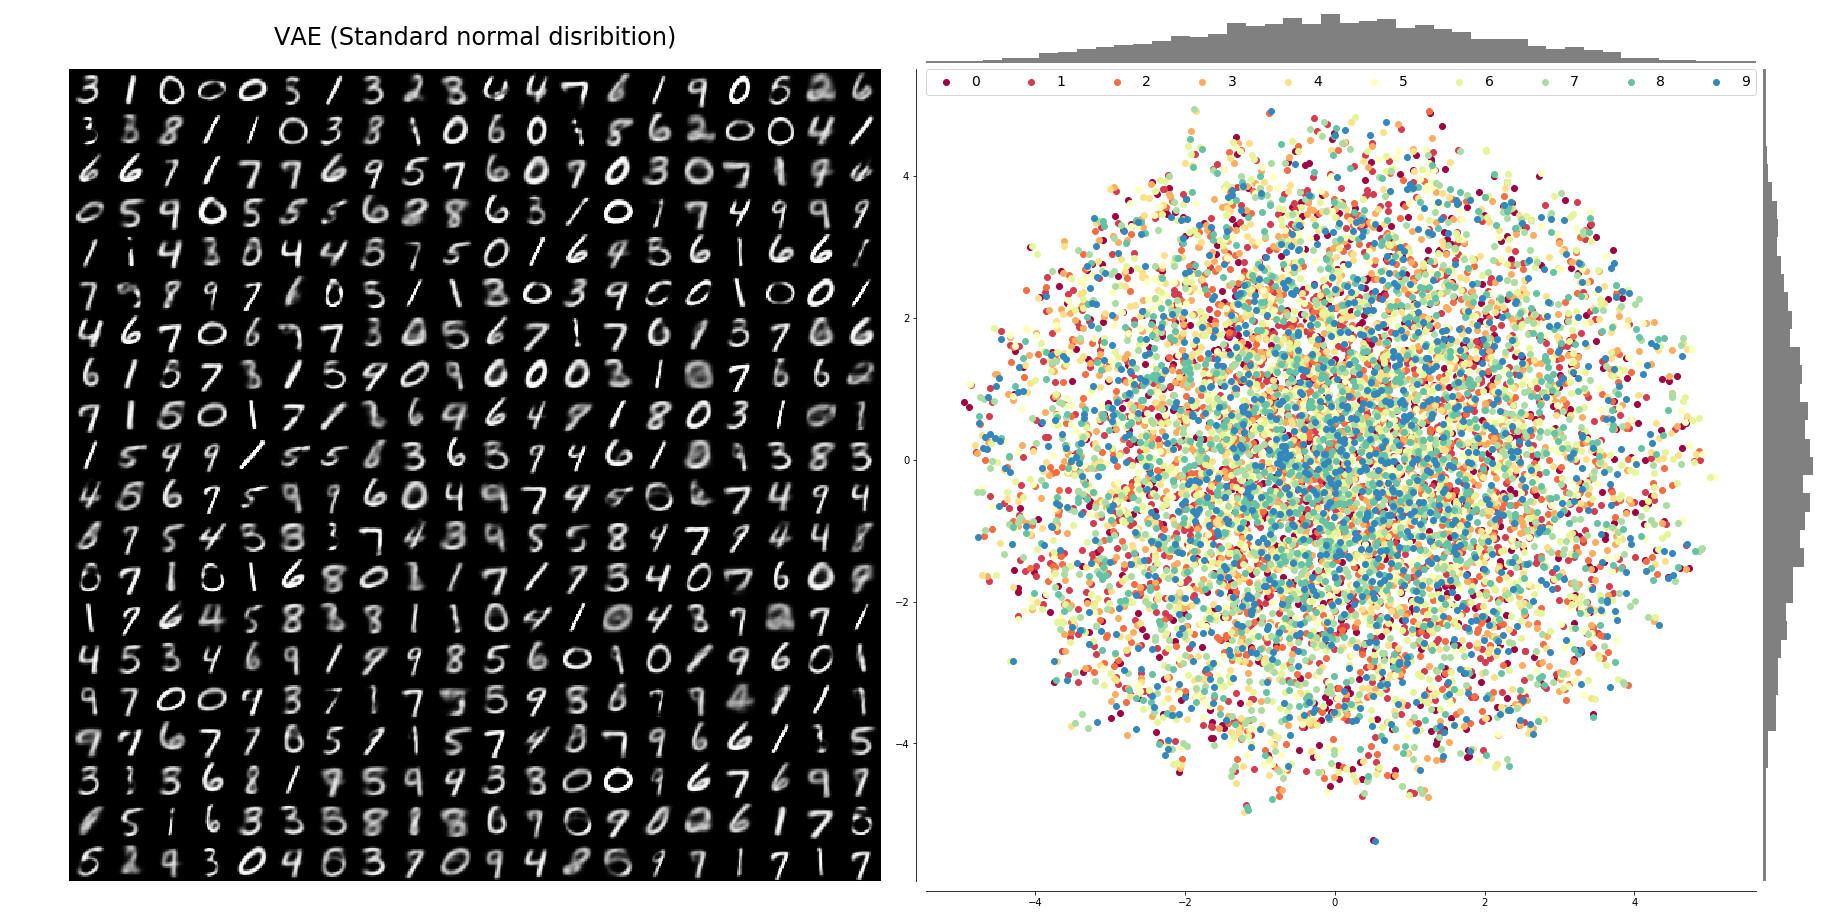

In [11]:
n_points = 20
z_samples = np.random.standard_normal(size=(n_points ** 2, LATENT_DIM))

x_samples_img = decoder.predict(z_samples).reshape((n_points, n_points, 28, 28))
x_samples_img = np.concatenate(x_samples_img, axis=-1)
x_samples_img = np.concatenate(x_samples_img, axis=0)

z_points, z_mean_test, z_log_sigma_test = encoder.predict(x_test)
z_points = TSNE(n_components=2, n_jobs=8).fit_transform(z_points)

visualize('VAE (Standard normal disribition)', x_samples_img, None, z_points, y_test)

<br>Statistics

In [12]:
z_samples.mean(), z_samples.std()

(-0.005221739933541825, 0.9977461632614192)

In [13]:
z_mean_test.mean(), z_mean_test.std()

(0.0008384203, 0.12027095)

In [14]:
np.exp(z_log_sigma_test).mean(), np.exp(z_log_sigma_test).std()

(0.9652441, 0.15326466)

<br>Kullback–Leibler divergence

In [15]:
np.mean(-0.5 * np.mean(1 + z_log_sigma_test - np.square(z_mean_test) - np.exp(z_log_sigma_test), axis=-1))

0.027699225

Entropy

In [16]:
Q, _ = np.histogram(z_points, bins=100, range=(-1, 1), density=True)
P, _ = np.histogram(np.random.normal(size=z_points.shape), bins=100, range=(-1, 1), density=True)
entropy(P, Q)

0.0225790653065901

# Adversarial Variational Bayes

### Definition and training

In [17]:
# Encoder
inp_encoder_x = Input((INPUT_DIM,))
inp_encoder_noise = Input((LATENT_DIM,))
e = concatenate([inp_encoder_x, inp_encoder_noise])

e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(LATENT_DIM, activation='linear')(e)

encoder = Model([inp_encoder_x, inp_encoder_noise], e, name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Discriminator
inp_discriminator_x = Input((INPUT_DIM,))
inp_discriminator_z = Input((LATENT_DIM,))
a = concatenate([inp_discriminator_x, inp_discriminator_z])
a = GradientReversal()(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(1, activation='sigmoid')(a)

discriminator = Model([inp_discriminator_x, inp_discriminator_z], a, name='discriminator')

# Stacking all together
inp_x = Input((INPUT_DIM,))
inp_noise = Input((LATENT_DIM,))
prior_distribution = Input((LATENT_DIM,))

reconstruction = decoder(encoder([inp_x, inp_noise]))
discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator([inp_x, encoder([inp_x, inp_noise])]))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator([inp_x, prior_distribution]))

trainable = Model([inp_x, inp_noise, prior_distribution], [reconstruction, discriminator_fake, discriminator_real])
trainable.compile('rmsprop', 'binary_crossentropy')
# trainable.summary()

In [18]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                input_noise = np.random.uniform(size=(batch_size, LATENT_DIM))
                prior_noise = np.random.standard_normal((batch_size, LATENT_DIM))
                
                yield [X, input_noise, prior_noise], [X, zeros, ones]
                
    return generator(), n_steps

In [19]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

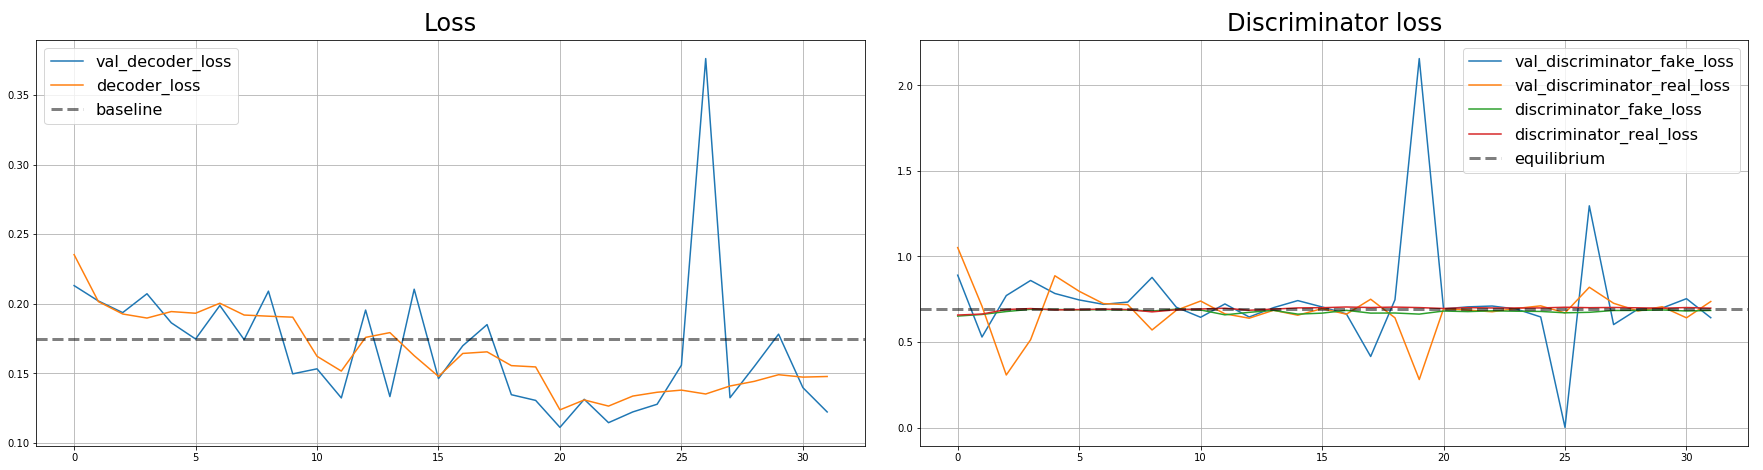

In [20]:
trainable.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=N_EPOCH, verbose=0, 
                    callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{'baseline': 0.175}}, 
                                                  {'text':'Discriminator loss', 'loss_signature':'discriminator', 'constants':{'equilibrium': -np.log(0.5)}}))],
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

### Results

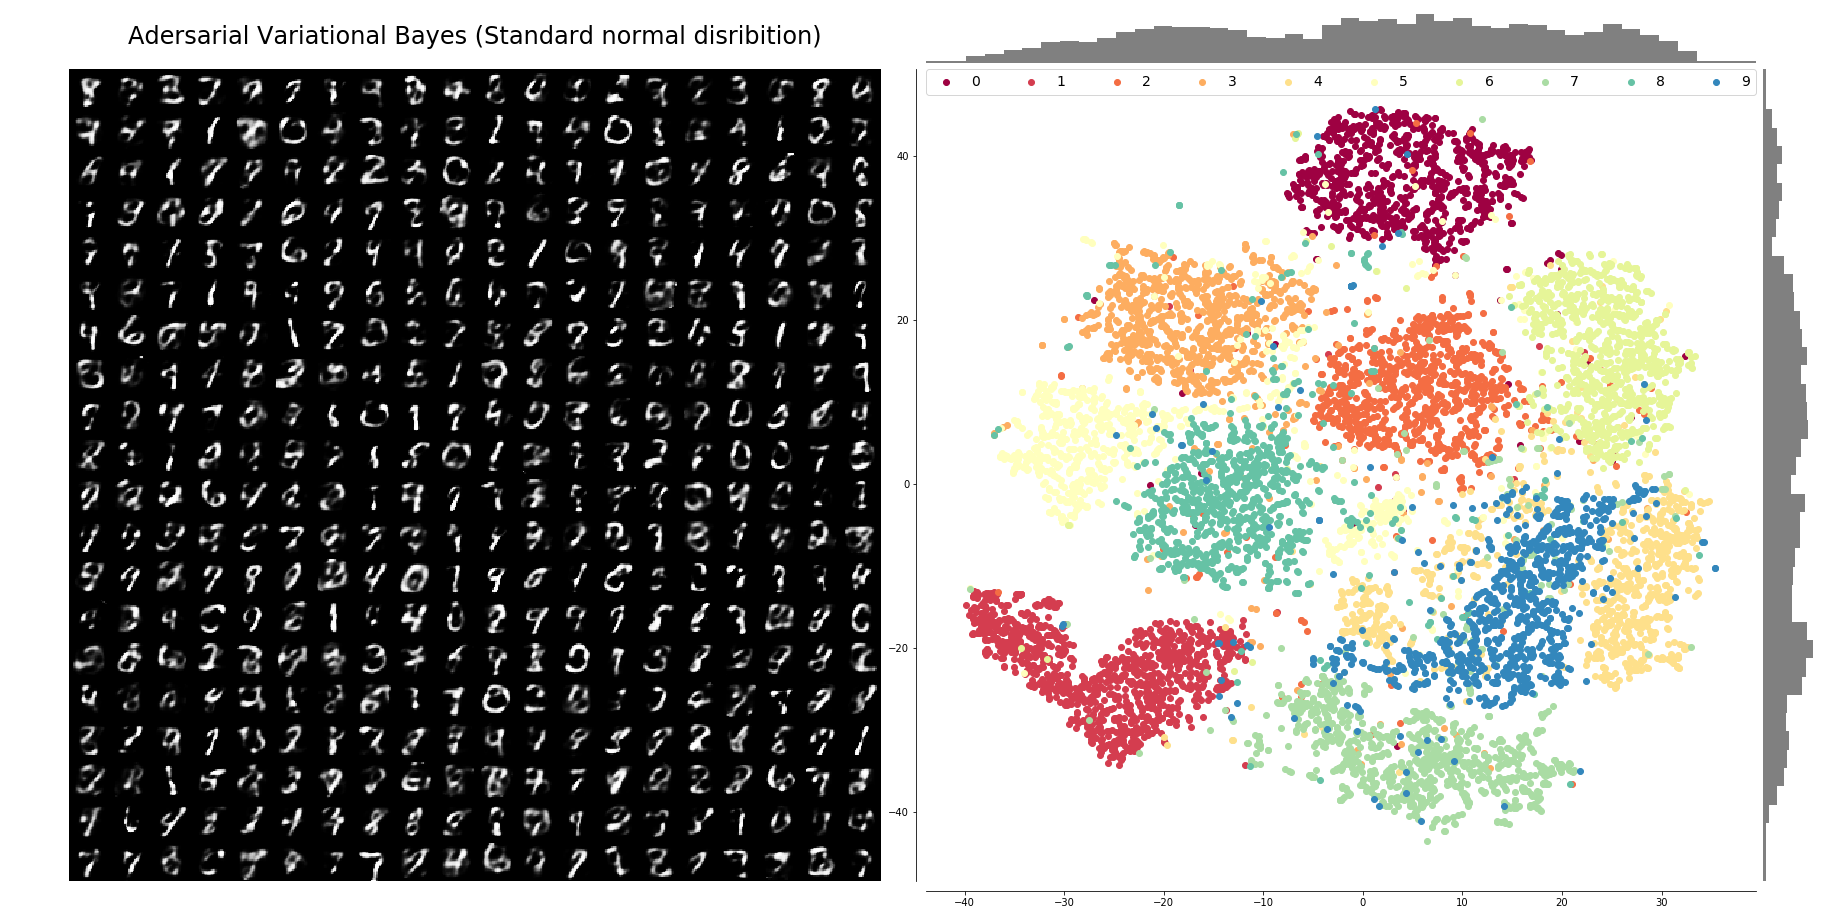

In [22]:
n_points = 20
z_samples = np.random.standard_normal(size=(n_points ** 2, LATENT_DIM))

x_samples_img = decoder.predict(z_samples).reshape((n_points, n_points, 28, 28))
x_samples_img = np.concatenate(x_samples_img, axis=-1)
x_samples_img = np.concatenate(x_samples_img, axis=0)

z_points = encoder.predict([x_test, np.random.standard_normal((x_test.shape[0], LATENT_DIM))])
z_points = TSNE(n_components=2, n_jobs=8).fit_transform(z_points)

visualize('Adversarial Variational Bayes (Standard normal disribition)', x_samples_img, None, z_points, y_test)

<br>Statistics

In [23]:
z_samples.mean(), z_samples.std()

(0.010022161868312111, 1.0006029516722261)

Entropy

In [24]:
Q, _ = np.histogram(z_points, bins=100, range=(-1, 1), density=True)
P, _ = np.histogram(np.random.normal(size=z_points.shape), bins=100, range=(-1, 1), density=True)
entropy(P, Q)

0.09455601218162071

# Adversarial Variational Bayes with Adaptive Contrast

In [25]:
NOISE_BASIS_DIM = 32

### Definition and training

In [26]:
# Encoder
inp_encoder_x = Input((INPUT_DIM,))
e = inp_encoder_x

e = Dense(HIDDEN_DIM, activation='relu')(e)
e = Dense(HIDDEN_DIM, activation='relu')(e)
e = RepeatVector(NOISE_BASIS_DIM)(e)
e = LocallyConnected1D(LATENT_DIM, kernel_size=1, activation='linear')(e)

inp_encoder_noise = Input((NOISE_BASIS_DIM * LATENT_DIM,))
n = inp_encoder_noise

n = Reshape((NOISE_BASIS_DIM, LATENT_DIM))(n)
n = LocallyConnected1D(LATENT_DIM, kernel_size=1, activation='relu')(n)
n = LocallyConnected1D(LATENT_DIM, kernel_size=1, activation='linear')(n)

z = Lambda(lambda x: K.sum(x[0]*x[1], axis=1))([e, n])
empirical_mean = Lambda(lambda x: K.sum(K.mean(x[0], axis=0, keepdims=True)*x[1], axis=1))([e, n])
empirical_std = Lambda(lambda x: K.sqrt(K.sum(K.var(x[0], axis=0, keepdims=True)*K.square(x[1]), axis=1)))([e, n])

encoder = Model([inp_encoder_x, inp_encoder_noise], [z, empirical_mean, empirical_std], name='encoder')

# Decoder
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)
d = Dense(HIDDEN_DIM, activation='relu')(d)
d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

# Discriminator
inp_discriminator_x = Input((INPUT_DIM,))
inp_discriminator_z = Input((LATENT_DIM,))
a = concatenate([inp_discriminator_x, inp_discriminator_z])
a = GradientReversal()(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(HIDDEN_DIM, activation='relu')(a)
a = Dense(1, activation='sigmoid')(a)

discriminator = Model([inp_discriminator_x, inp_discriminator_z], a, name='discriminator')

# Stacking all together
inp_x = Input((INPUT_DIM,))
inp_noise = Input((NOISE_BASIS_DIM * LATENT_DIM,))
inp_prior = Input((LATENT_DIM,))

z_, mean_, std_ = encoder([inp_x, inp_noise])

reconstruction = decoder(z_)

z_ = Lambda(lambda x: (x[0] - K.stop_gradient(x[1])) / K.stop_gradient(x[2]))([z_, mean_, std_])
discriminator_fake = Lambda(lambda x: x, name='discriminator_fake')(discriminator([inp_x, z_]))
discriminator_real = Lambda(lambda x: x, name='discriminator_real')(discriminator([inp_x, inp_prior]))

trainable = Model([inp_x, inp_noise, inp_prior], [reconstruction, discriminator_fake, discriminator_real])
trainable.compile('rmsprop', 'binary_crossentropy')
# trainable.summary()

In [27]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    ones = np.ones(batch_size)
    zeros = np.zeros(batch_size)
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                input_noise = np.random.standard_normal(size=(batch_size, NOISE_BASIS_DIM * LATENT_DIM))
                prior_noise = np.random.standard_normal((batch_size, LATENT_DIM))
                
                yield [X, input_noise, prior_noise], [X, zeros, ones]
                
    return generator(), n_steps

In [28]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

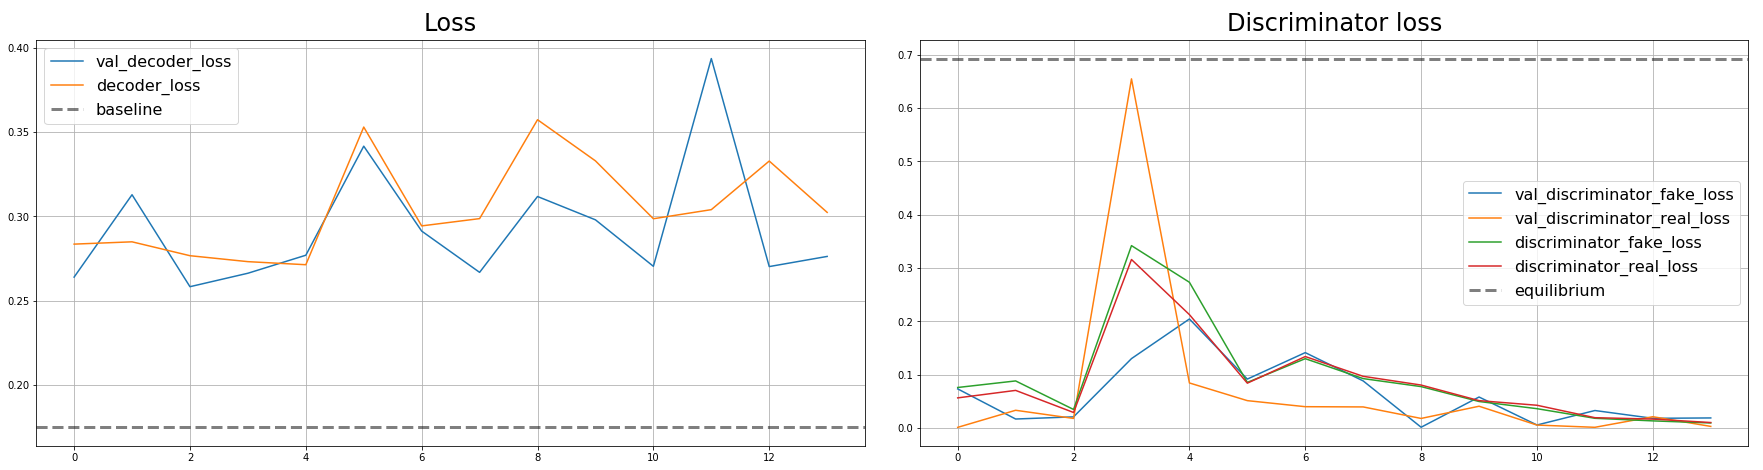

KeyboardInterrupt: 

In [29]:
trainable.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=N_EPOCH, verbose=0, 
                    callbacks=[VisualizeTraining(({'text':'Loss', 'loss_signature':'decoder', 'constants':{'baseline': 0.175}}, 
                                                  {'text':'Discriminator loss', 'loss_signature':'discriminator', 'constants':{'equilibrium': -np.log(0.5)}}))],
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

### Results

In [ ]:
n_points = 20
z_samples = np.random.standard_normal(size=(n_points ** 2, LATENT_DIM))

x_samples_img = decoder.predict(z_samples).reshape((n_points, n_points, 28, 28))
x_samples_img = np.concatenate(x_samples_img, axis=-1)
x_samples_img = np.concatenate(x_samples_img, axis=0)

z_points = encoder.predict([x_test, np.random.standard_normal((x_test.shape[0], LATENT_DIM))])
z_points = TSNE(n_components=2, n_jobs=8).fit_transform(z_points)

visualize('Adersarial Variational Bayes with Adaptive Contrast (Standard normal disribition)', x_samples_img, None, z_points, y_test)

<br>Statistics

In [ ]:
z_samples.mean(), z_samples.std()

Entropy

In [ ]:
Q, _ = np.histogram(z_points, bins=100, range=(-1, 1), density=True)
P, _ = np.histogram(np.random.normal(size=z_points.shape), bins=100, range=(-1, 1), density=True)
entropy(P, Q)